In [13]:
from library.objective_function import *
from library.optimiser import *
from library.post_analysis import *
%matplotlib inline

In [14]:
class post_analysis_multiple:
    def __init__(self, paras, data):
        self.paras = paras
        self.origin = paras['origin']
        self.edge = paras['edge']
        self.step = paras['step']
        self.size = paras['size']
        self.sym = paras['sym'] if 'sym' in self.paras.keys() else False
        
        self.x = data['x']
        self.y = data['y']
        self.prob = data['res']
        self.cost = data['cost']
        self.evals = data['evals']
        self.mask = data['mask']
    def plot_scatter(self):
        fig = plt.figure(figsize=(10,10))
        sc = plt.scatter(self.x.ravel(), self.y.ravel(), c=self.prob.ravel(), marker='o', vmin=0, vmax=1, s=35, cmap='YlGnBu')
        plt.colorbar(sc)
    def plot_hotmap_prob(self):
        with sns.axes_style("white"):
            fig = plt.figure(figsize=(13, 13))
            ax = sns.heatmap(self.prob, mask=self.mask, vmin=0, vmax=1, square=True,  cmap="YlGnBu")
            ax.set_xticklabels(np.arange(self.origin[0], self.origin[0] + self.edge[0], self.step) + round(self.step/2))
            ax.set_yticklabels(np.arange(self.edge[1] + self.origin[1], self.origin[1], -self.step) - round(self.step/2))
    def plot_hotmap_cost(self):
        with sns.axes_style("white"):
            fig = plt.figure(figsize=(13, 13))
            ax = sns.heatmap(self.cost, mask=self.mask, vmin=0, square=True,  cmap="YlGnBu")
            ax.set_xticklabels(np.arange(self.origin[0], self.origin[0] + self.edge[0], self.step) + round(self.step/2))
            ax.set_yticklabels(np.arange(self.edge[1] + self.origin[1], self.origin[1], -self.step) - round(self.step/2))
    def plot_hotmap_evals(self):
        with sns.axes_style("white"):
            fig = plt.figure(figsize=(13, 13))
            ax = sns.heatmap(self.evals, mask=self.mask, vmin=0, square=True,  cmap="YlGnBu")
            ax.set_xticklabels(np.arange(self.origin[0], self.origin[0] + self.edge[0], self.step) + round(self.step/2))
            ax.set_yticklabels(np.arange(self.edge[1] + self.origin[1], self.origin[1], -self.step) - round(self.step/2))

In [15]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        cost = np.linalg.norm(optimum - self.objective_func.get_optimum())
        if self.optimizer.verbose:
            print("\nResult: ", statistics['status'])
            print("Cost_val", cost)
        if self.optimizer.record == False:
            return statistics['status'], cost, statistics['evals']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [16]:
class multiple_experiment:
    def set_sample_zone(self, paras):
        self.paras = paras
        self.origin = paras['origin']
        self.edge = paras['edge']
        self.step = paras['step']
        self.sym = paras['sym'] if 'sym' in self.paras.keys() else False
        self.size = paras['size']
    def set_single_exp(self, exp):
        self.exp = exp
    def do(self):
        # get derivative parameters
        num_x = int(self.edge[0] / self.step)
        num_y = int(self.edge[1] / self.step)
        abs_edge = np.zeros((2,))
        abs_edge[0] = self.origin[0] + self.edge[0]
        
        # initlise matrix to record results
        avg_res = np.zeros((num_y, num_x))
        avg_cost = np.zeros_like(avg_res)
        avg_evals = np.zeros_like(avg_res)
        mask = np.ones_like(avg_res, dtype=np.uint8)
        position_x = np.zeros_like(avg_res)
        position_y = np.zeros_like(avg_res)
        
        for i, x in enumerate(np.arange(self.origin[0], abs_edge[0], self.step)):
            if self.sym:
                abs_edge[1] = self.origin[1] + x + self.step 
            else:
                abs_edge[1] = self.origin[1] + self.edge[1]
            for j, y in enumerate(np.arange(self.origin[0], abs_edge[1], self.step)):
                points = np.random.rand(self.size, 2) * self.step + np.array([x, y]) 
                mask[num_y-1-j, i] = 0
                position_x[num_y-1-j, i] = x
                position_y[num_y-1-j, i] = y
                opt_paras = self.exp.optimizer.paras
                # calculate the probility of getting global minimum 
                res = np.zeros((self.size, ))
                costs = np.zeros_like(res)
                evals = np.zeros_like(res)
                for k in range(self.size):
                    opt_paras['mean0'] = points[k].reshape(2,1)
                    self.exp.optimizer.set_parameters(opt_paras)
                    status, costs[k], evals[k] = self.exp.do()
                    if(status == 'global minimum'):
                        res[k] = 1
                avg_res[num_y-1-j, i] = np.mean(res)
                avg_cost[num_y-1-j, i] = np.mean(costs)
                avg_evals[num_y-1-j, i] = np.mean(evals)
        data = {'x': position_x, 
                'y': position_y,
                'mask': mask,
                'res': avg_res,
                'cost': avg_cost,
                'evals': avg_evals}
        self.analyser = post_analysis_multiple(self.paras, data)
        return data

# Original Ackley + Original CMA

In [25]:
np.random.seed(23191)

# init multiple experiments
exps = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
ak = ackley()
exp.set_objective(ak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0,0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}
exps.set_sample_zone(expsParas)

data = exps.do()

/Users/huajian/Non-convex/library/optimiser.py:199: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/Non-convex/library/optimiser.py:90: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:93: RuntimeWarning:

invalid value encountered in less



diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, raise LinAlgError!
diverge, concentrate in low dimension manifold
diverge, raise LinAlgError!
diverge, raise LinAlgError!


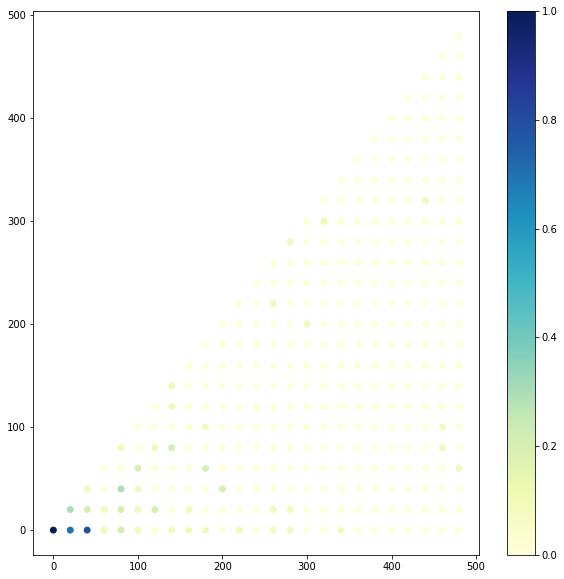

In [26]:
exps.analyser.plot_scatter()

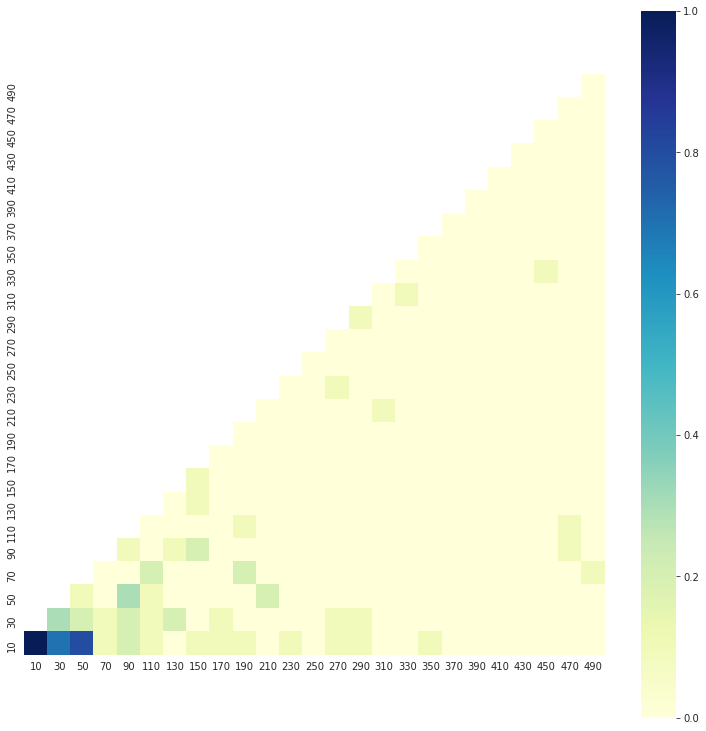

In [27]:
exps.analyser.plot_hotmap_prob()

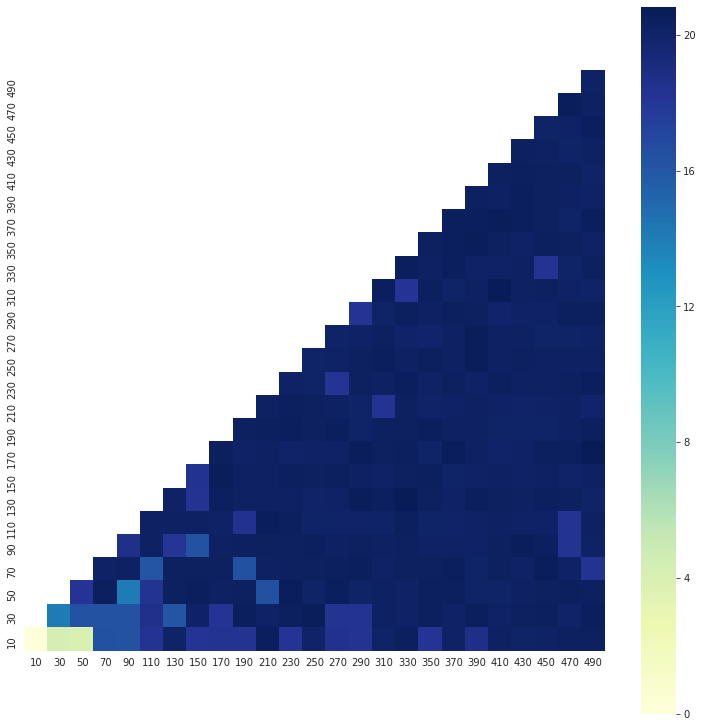

In [28]:
exps.analyser.plot_hotmap_cost()

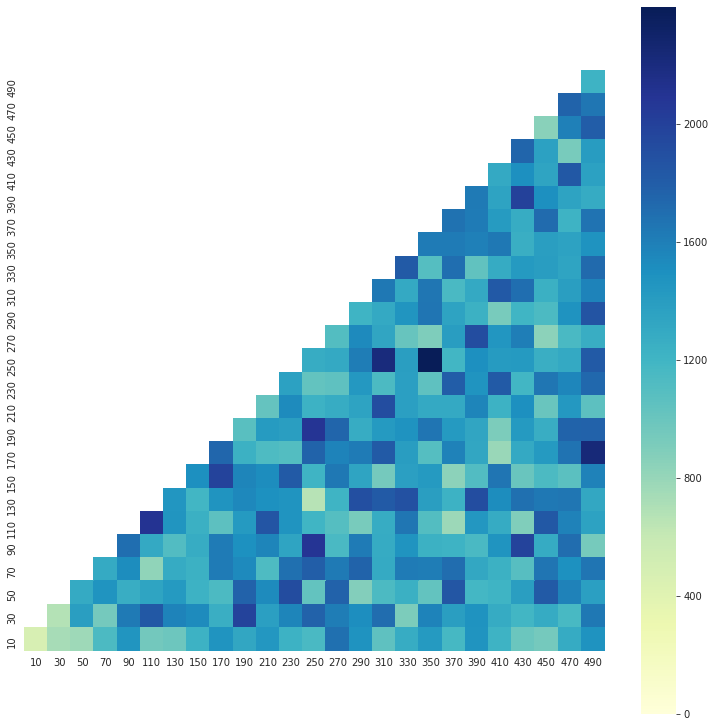

In [29]:
exps.analyser.plot_hotmap_evals()

In [ ]:
np.random.seed(23191)

# init multiple experiments
exps = multiple_experiment()

# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
ak = ackley()
exp.set_objective(ak)

# One experiment: setup optimizer
cma = cma_es()
paras = {'mean0': np.zeros((2,)),
         'std': np.ones((2,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': False}
cma.set_parameters(paras)
exp.set_optimizer(cma)

# Multiple experiment: setup one expreiment
exps.set_single_exp(exp)


# Multiple experiments: setup sample zone of multiple experiments
expsParas = {'origin': np.array([0,0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}
exps.set_sample_zone(expsParas)

data = exps.do()